In [31]:
import h5py
from dspeed import build_dsp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import scipy.special as sp


In [ ]:
### A Digital Signal Processing notebook that has a few visualization methods to get a sense of the optimal DSP settings
### for applying the LEGEND DSP routines to the Silicon detector data.

In [23]:
file = "DataR_CH1@DT5725_1146_run_2.lh5" # path to raw file
dsp_file = "DataR_CH1@DT5725_1146_run_2_dsp.lh5" # path to output dsp file

This DSP configuration file will produce the `trapEftp` parameter. You can scroll to the bottom and work your way back to see all the processors we need to generate it.

There are a couple of parameters that can be optimized in order to get the best energy resolution:
<ul>
    <li> pz_tau </li>
    <li> etrap.rise  </li>
    <li> etrap.flat </li>
    <li> ftp </li>
</ul>

We know what `pz_tau` should be from the decay constant measurement, so we don't need to optimize it.

`etrap.flat` just needs to be decently longer than the rise time of the waveform, so don't worry about it too much

`ftp` is set relative to the parameter of the energy trapezoid, to make sure that we're picking from the flat top

That leaves `etrap.flat` to be optimized. You can do this manually, by just typing in different numbers into the cell below. You can also write some code to loop through some numbers and run the DSP. Your optimization condition is when your peak has the best resolution - either minimize the width or maximize the height. 


In [24]:
dsp_config = {
    "outputs": ["bl", "trapEftp", "wf_pz", "wf_blsub", "wf_etrap"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [25]:
rises = np.linspace(1.5, 5, 30) # Change this
flats = np.linspace(0.1, 2.5, 20)

trap_data = [[None]*len(flats) for _ in range(len(rises))] 
print(trap_data)
print(np.shape(trap_data))

for i, rise in enumerate(rises):
    for j, flat in enumerate(flats):
        dsp_db = {
            "CompassEvent": {
                "pz_tau": "0.5*ms",
                "etrap": {
                    "rise": f"{rise}*us",
                    "flat": f"{flat}*us"
                },
                "ftp": 1000 + (rise + 0.5*flat)/(0.004)
            }
        }

        build_dsp(
            f_raw=file, 
            f_dsp="DataR_CH1@DT5725_1146_run_2_dsp.lh5",
            lh5_tables = "CompassEvent",
            dsp_config = dsp_config,
            database = dsp_db,
            write_mode = 'r'
        )

        f = h5py.File(dsp_file)
        trapEftp = f['CompassEvent']['trapEftp']
        trap_data[i][j] = trapEftp


[[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None

Processing table CompassEvent: 100%|██████████| 5066/5066 [00:05<00:00, 981.12 rows/s]


Rise: 1.5us, Flat: 0.1us
Mean: 569.5243253382132, FWHM: 34.017728943805636, Energy FWHM: 195.38901144370584, Energy Resolution: 0.05973007197472055
Rise: 1.5us, Flat: 0.22631578947368422us
Mean: 575.2703383781685, FWHM: 31.71570422306492, Energy FWHM: 180.34722935130426, Energy Resolution: 0.055131826042829624
Rise: 1.5us, Flat: 0.3526315789473684us
Mean: 567.8049511743384, FWHM: 36.06401563333415, Energy FWHM: 207.76960062741767, Energy Resolution: 0.06351479598539303
Rise: 1.5us, Flat: 0.4789473684210527us
Mean: 567.2512923185859, FWHM: 36.75278003102578, Energy FWHM: 211.94432814084985, Energy Resolution: 0.06479100273320185


/tmp/ipykernel_10908/2076363656.py:31: RuntimeWarning: overflow encountered in exp
  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))
/tmp/ipykernel_10908/2076363656.py:31: RuntimeWarning: invalid value encountered in multiply
  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))
/tmp/ipykernel_10908/2076363656.py:30: RuntimeWarning: overflow encountered in exp
  return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
/tmp/ipykernel_10908/2076363656.py:30: RuntimeWarning: invalid value encountered in multiply
  return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))


Rise: 1.5us, Flat: 0.6052631578947368us
Mean: 579.6400962526113, FWHM: 81.32903255595524, Energy FWHM: 458.9805519269962, Energy Resolution: 0.1403095353163965
Rise: 1.5us, Flat: 0.731578947368421us
Mean: 566.3863893993954, FWHM: 37.27286515502946, Energy FWHM: 215.27176284095663, Energy Resolution: 0.06580819358062993
Rise: 1.5us, Flat: 0.8578947368421053us
Mean: 566.0873652655858, FWHM: 37.20155884772992, Energy FWHM: 214.97342419151187, Energy Resolution: 0.06571699198811197
Rise: 1.5us, Flat: 0.9842105263157895us
Mean: 571.4628534711277, FWHM: 34.38830984712368, Energy FWHM: 196.84750896515519, Energy Resolution: 0.06017593206320469
Rise: 1.5us, Flat: 1.1105263157894738us
Mean: 565.6223145807039, FWHM: 36.348323040423175, Energy FWHM: 210.2156001712465, Energy Resolution: 0.06426253367915338
Rise: 1.5us, Flat: 1.236842105263158us
Mean: 565.4918483930679, FWHM: 35.64309379398939, Energy FWHM: 206.18456083889214, Energy Resolution: 0.06303025215177675
Rise: 1.5us, Flat: 1.36315789473

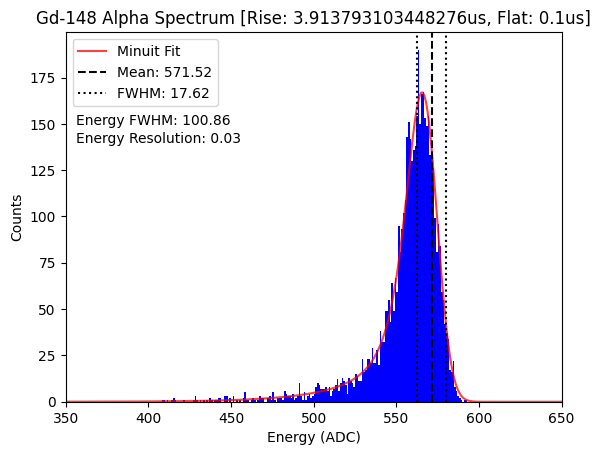

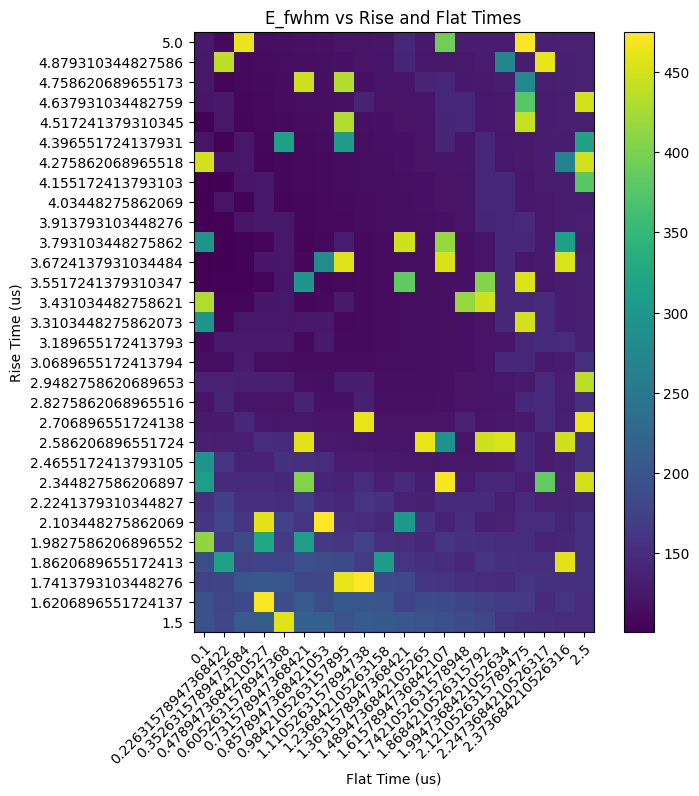

"\nnoise_cut = select_n_cut(0,0)\nplt.hist(noise_cut, bins=bins, color='blue')\ncounts, _ = np.histogram(noise_cut, bins=bins) \nminuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution = optimizer(counts)\n\n#manual_fit = A_fit * fit_func(x, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)\n#cdf_fit = cdf_fit_func(x, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)\n\n"

In [26]:
def select_n_cut(i,j):
    noise_cut = trap_data[i][j][:]
    noise_cut = noise_cut[noise_cut > 400]
    return noise_cut


####################################
### Define Global Variables Here ###
####################################

x = np.linspace(0, 1000, 1001)   #need
bins = np.linspace(0, 1000, 1001)   #need   
_, bin_edges = np.histogram(select_n_cut(0,0), bins=bins)  #need
binwidth = bin_edges[1] - bin_edges[0]      #need

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2      # sorta need later

#plt.hist(noise_cut, bins=bins, color='blue')



#mean = np.mean(noise_cut) + 6
#std = np.std(noise_cut) - 14
#fwhm = 2.355*std


# Define the fit function 
def fit_func(x, mu, sigma, eta, tau1, tau2):
    #mean = 559.53
    return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
                  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))

#test_fit = fit_func(x, mean, std, eta=-10, tau1=20, tau2=20)

def cdf_fit_func(x, A, mu, sigma, eta, tau1, tau2):
    return A * np.cumsum(fit_func(x, mu, sigma, eta, tau1, tau2)) * binwidth

def optimizer(counts, gimme_moar=False):
    c = cost.ExtendedBinnedNLL(counts, bin_edges, cdf_fit_func)
    m = Minuit(c, A=10000, mu=559, sigma=15, eta=-10, tau1=20, tau2=20)
    m.limits["A"] = (2000, 10000)
    m.limits["sigma"] = (5,35)
    m.limits["tau1"] = (1, 100)
    m.limits["tau2"] = (1, 100)
    m.limits['eta'] = (0,1)
    var = m.migrad()
    A_fit = m.values['A']
    mean_fit = m.values['mu']
    std_fit = m.values['sigma']
    eta_fit = m.values['eta']
    tau1_fit = m.values['tau1']
    tau2_fit = m.values['tau2']
    fwhm_fit = 2.355*std_fit
    energy_fwhm = fwhm_fit*3271.2/mean_fit
    energy_resolution = fwhm_fit/mean_fit

    minuit_fit = A_fit * fit_func(x, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)
    if gimme_moar:
        return minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution
    else:
        return minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution

def plot_fit(noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, rise = False, flat = False):
    #plt.plot(x, test_fit, color='green', label='Test Fit', alpha = 0.75)
    plt.hist(noise_cut, bins=bins, color='blue')
    plt.plot(x, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
    #plt.plot(x, cdf_fit, color='green', label='CDF Fit', alpha = 0.75)
    plt.axvline(mean_fit, color='black', linestyle='--', label='Mean: ' + str(round(mean_fit, 2)))
    plt.axvline(mean_fit + fwhm_fit/2, color='black', linestyle=':', label='FWHM: ' + str(round(fwhm_fit, 2)))
    plt.axvline(mean_fit - fwhm_fit/2, color='black', linestyle=':')
    plt.text(0.02, 0.7, 'Energy Resolution: ' + str(round(energy_resolution, 2)), transform=plt.gca().transAxes)
    plt.text(0.02, 0.75, 'Energy FWHM: ' + str(round(energy_fwhm, 2)), transform=plt.gca().transAxes)
    plt.xlim(350, 650)

    if rise and flat:
        plt.title(f'Gd-148 Alpha Spectrum [Rise: {rise}us, Flat: {flat}us]')
    else:
        plt.title('Gd-148 Alpha Spectrum')
    plt.xlabel('Energy (ADC)')
    plt.ylabel('Counts')
    #plt.ylim(1e-2, 2e2)
    #plt.yscale('log')
    plt.legend()
    plt.show()


def plot_heat_map(e_fwhm_array):
    figgy, axs = plt.subplots(figsize=(10, 10))
    im = axs.imshow(e_fwhm_array, origin='lower')
    axs.set_xticks(np.arange(len(flats)), labels=flats)
    axs.set_yticks(np.arange(len(rises)), labels=rises)
    plt.setp(axs.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    axs.set_title("E_fwhm vs Rise and Flat Times")
    axs.set_xlabel("Flat Time (us)")
    axs.set_ylabel("Rise Time (us)")
    plt.colorbar(im)
    figgy.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.show()

fits = [[None]*len(flats) for _ in range(len(rises))]
e_fwhm_array = np.zeros((len(rises), len(flats)))
#print(np.shape(e_fwhm_array))

#fig, ax = plt.subplots(len(rises), len(flats), figsize=(10,10))

for i in range(len(rises)):
    for j in range(len(flats)):
        noise_cut = select_n_cut(i,j)
        counts, _ = np.histogram(noise_cut, bins=bins)  #need
        minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution = optimizer(counts)
        e_fwhm_array[i][j] = energy_fwhm
        fits[i][j] = minuit_fit
        #plot_data(ax[i,j], noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution)
        print(f'Rise: {rises[i]}us, Flat: {flats[j]}us')
        print(f'Mean: {mean_fit}, FWHM: {fwhm_fit}, Energy FWHM: {energy_fwhm}, Energy Resolution: {energy_resolution}')

#print(e_fwhm_array)

# Find the index of the minimum element
min_index = np.argmin(e_fwhm_array)
row, col = np.unravel_index(min_index, e_fwhm_array.shape)  # Convert the flattened index to row and column indices
print(row,col)
print(f'Rise: {rises[row]}us, Flat: {flats[col]}us')
best_data = select_n_cut(row, col)
best_counts, _ = np.histogram(best_data, bins=bins)  #need
minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution = optimizer(best_counts, gimme_moar=True)
plot_fit(best_data, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, rise = rises[row], flat = flats[col])



plot_heat_map(e_fwhm_array)



#Testing Block
'''
noise_cut = select_n_cut(0,0)
plt.hist(noise_cut, bins=bins, color='blue')
counts, _ = np.histogram(noise_cut, bins=bins) 
minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution = optimizer(counts)

#manual_fit = A_fit * fit_func(x, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)
#cdf_fit = cdf_fit_func(x, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)

'''


(350.0, 650.0)

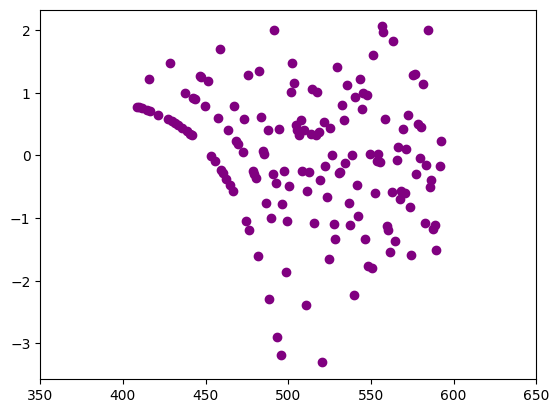

In [27]:
params = [A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit]
residuals = c.pulls(params)

plt.scatter(bin_centers, residuals, color='purple', label='Residuals')
plt.xlim(350, 650)

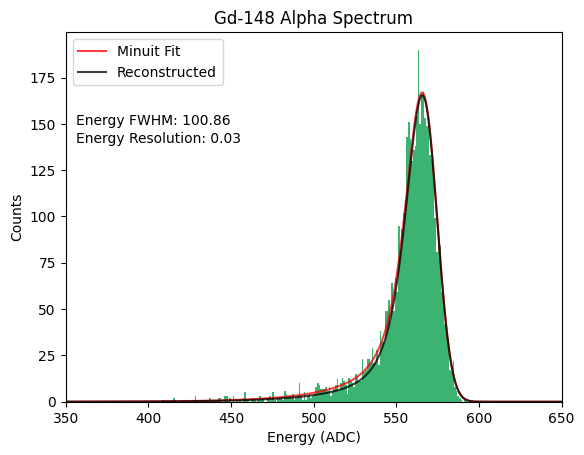

In [28]:
def term1(x, A, mu, sigma, eta, tau1):
    return A * 0.5 * ((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
    
def term2(x, A, mu, sigma, eta, tau2):
    return A * 0.5 * (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2)))

eta_mod = eta_fit + 0.07
tau1_mod = tau1_fit + 1
tau2_mod = tau2_fit + 1
test_term1 = term1(x, A_fit, mean_fit, std_fit, eta_mod, tau1_fit)
test_term1a = term1(x, A_fit, mean_fit, std_fit, eta_fit, tau1_mod)
test_term2 = term2(x, A_fit, mean_fit, std_fit, eta_mod, tau2_fit)
test_term2a = term2(x, A_fit, mean_fit, std_fit, eta_fit, tau2_mod)
reconstructed = 0.95 * (test_term1 + test_term2)

plt.hist(best_data, bins=bins, color='mediumseagreen')
plt.plot(x, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
#plt.plot(x, test_term1, color='green', label='Term 1', alpha = 0.75)
#plt.plot(x, test_term1a, color='orange', label='Term 1 tau mod', alpha = 0.75)
#plt.plot(x, test_term2, color='purple', label='Term 2', alpha = 0.75) 
plt.plot(x, reconstructed, color='black', label='Reconstructed', alpha = 0.75)
#plt.plot(x, cdf_fit, color='green', label='CDF Fit', alpha = 0.75)
#plt.axvline(mean_fit, color='black', linestyle='--', label='Mean: ' + str(round(mean_fit, 2)))
#plt.axvline(mean_fit + fwhm_fit/2, color='black', linestyle=':', label='FWHM: ' + str(round(fwhm_fit, 2)))
#plt.axvline(mean_fit - fwhm_fit/2, color='black', linestyle=':')
plt.text(0.02, 0.7, 'Energy Resolution: ' + str(round(energy_resolution, 2)), transform=plt.gca().transAxes)
plt.text(0.02, 0.75, 'Energy FWHM: ' + str(round(energy_fwhm, 2)), transform=plt.gca().transAxes)
plt.xlim(350, 650)
plt.title('Gd-148 Alpha Spectrum')
plt.xlabel('Energy (ADC)')
plt.ylabel('Counts')
#plt.ylim(1e-2, 2e2)
#plt.yscale('log')
plt.legend()


I included `wf_blsub`, `wf_pz`, and `wf_etrap` in the output - normally we wouldn't save these since they take up a lot of space. You only have one file though, and it can be instructive to see what the actual output of the pole zero or trapezoidal filter looks like, and how it varies when you change the parameters. Below is some code to help you visualize it.

In [29]:
wf_blsub = f['CompassEvent']['wf_blsub']['values']
wf_pz = f['CompassEvent']['wf_pz']['values']
wf_etrap = f['CompassEvent']['wf_etrap']['values']

super_wf_blsub = np.average(wf_blsub/np.max(wf_blsub, axis=1)[:,None], axis=0)
super_wf_pz = np.average(wf_pz/np.max(wf_pz, axis=1)[:,None], axis=0)
super_wf_etrap = np.average(wf_etrap/np.max(wf_etrap, axis=1)[:,None], axis=0)

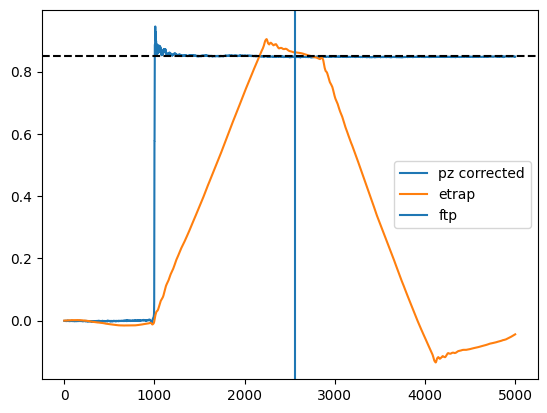

In [30]:
#plt.figure(figsize=(12,10))
#plt.plot(super_wf_blsub, label="original");
plt.plot(super_wf_pz, label="pz corrected");
plt.plot(super_wf_etrap, label="etrap");
plt.axvline(dsp_db["CompassEvent"]["ftp"], label="ftp");
plt.axhline(0.85, color='black', linestyle='--')
plt.legend()
#plt.xlim(500, 1500)